# Exploring Bike Sales
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/bike-sales/main.ipynb)._]

## Overview
We will be exploring how to use **Atoti** via an exploration of [Bike Sales data](https://www.kaggle.com/sadiqshah/bike-sales-in-europe) sourced from [kaggle](https://www.kaggle.com/).  Our main focus will be on the various ways one can slice and dice sales data.

### This guide will cover the following:
* What is Atoti
* Getting started with Atoti
* Creating and manipulating hierarchies and levels
* Visualizing sales data
* Creating aggregations
* Simulating alternate scenarios
* Creating a Dashboard

### What it won't cover:

[How to install Atoti](https://docs.atoti.io/latest/installation.html)

## What is Atoti?

<div style="text-align: center;"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=bike-sales" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/bike-sales/atoti-definition.PNG" alt="Try Atoti"></a></div>

## Getting Started

Refer to [Atoti's tutorial](https://docs.atoti.io/latest/tutorial/tutorial.html#Getting-started) for more examples on how to get started.  
Or check out the other notebooks in our [notebook gallery](https://github.com/atoti/notebooks/tree/master/notebooks).

We'll be completing this exploration of bike sales data using the Atoti library and a little bit of pandas.

In [1]:
import atoti as tt
import pandas as pd

In [2]:
session = tt.Session(
    user_content_storage="./content",
    port=9090,
)

We're including two configs while creating our session:
* one to specify the store our content metadata,
* and the other to specify a fixed port.

Both of these are optional to specify.  In this case, we set these configs so that we can store our dashboard for future reference, and we can access it from the same port each time.  If these were not set, the dashboard would not persist across sessions, and the access port for the dashboarding webapp would be randomly assigned.

We provide documentations about [creating a session](https://docs.atoti.io/latest/lib/atoti.html#atoti.Session) and what [configurations are available](https://docs.atoti.io/latest/lib/atoti.config.session_config.html#atoti.config.session_config.SessionConfig) to set up for further information.

Looking at the source data, we know there are some data values which, while numerical in nature, we want to treat as a hierarchy--that is, a categorical or hierarchical piece of information.  We'll list out all the columns we are certain are hierarchical.  If we missed any, we can always add it in later.

Hint--we purposefully "forgot" "Age_Group"

In [3]:
bike_sales = session.read_csv(
    "s3://data.atoti.io/notebooks/bike-sales/Sales.csv",
    default_values={"Day": 1, "Year": 1970},
)

bike_sales.head(3)

,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,26,October,2015,22,Youth (<25),F,Germany,Nordrhein-Westfalen,Accessories,Bottles and Cages,Mountain Bottle Cage,15,4,10,71,60,131
1,26,October,2015,22,Youth (<25),F,Germany,Nordrhein-Westfalen,Accessories,Bottles and Cages,Mountain Bottle Cage,3,4,10,14,12,26
2,19,April,2016,28,Young Adults (25-34),M,United States,Oregon,Accessories,Bottles and Cages,Water Bottle - 30 oz.,24,2,5,55,48,103


When creating our *cube*, Atoti is capable of using the inferred data type of columns to automatically create *measures* and *hierarchies* for us.  

In [4]:
cube = session.create_cube(bike_sales)

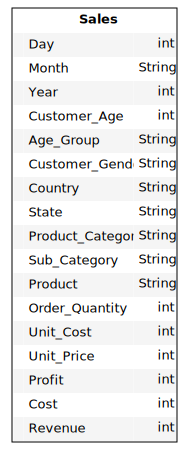

In [5]:
cube.schema

We can access the cube's attributes via `cube.hierarchies`, `cube.levels` and `cube.measures`. We can also simplify how we access our measures and hierarchies by assigning aliases. 

In [6]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Hierarchies and Levels

Within our table, we can slice our data along various categorical axes, which are our *hierarchies*.  *Hierarchies* consist of *levels*, where *levels* are attributes with a parent-child relationship.

Let's see what *hierarchies* and *levels* we have:

In [7]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFD3F0>, ('Sales', 'State'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCCD0>, ('Sales', 'Month'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCA90>, ('Sales', 'Country'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCA60>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCA30>, ('Sales', 'Sub_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC7C0>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC4F0>, ('Sales', 'Product_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC550>}

We see that all the non-numerical columns are created into single-level hierarchies.  
We could create hierarchies out of numerical columns as follows:

In [8]:
h.update(
    {
        name: {name: bike_sales[name]}
        for name in [
            "Day",
            "Year",
        ]
    }
)

In [9]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFEEF0>, ('Sales', 'State'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCFD0>, ('Sales', 'Month'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC970>, ('Sales', 'Country'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC040>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC130>, ('Sales', 'Sub_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFDAB0>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCC40>, ('Sales', 'Product_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC1C0>, ('Sales', 'Day'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFC730>, ('Sales', 'Year'): <atoti.hierarchy.Hierarchy object at 0x00000116A1CFCCA0>}

Some of the categorical columns we have as *levels* and *hierarchies* have an innate relationship with each other.  Dates are a great example of this (years contain months, months contain days).

We can create a calendar *hierarchy* using the year, month, and day *levels*.

In [10]:
h["Calendar"] = [l["Year"], l["Month"], l["Day"]]

We can also create an additional *hierarchy* (or *level*!) which categorizes or captures the seasonal nature of sales.  For example, we can create a new *level* called Quarter based off the month.

These classifications can naturally pop up as part of normal sales explorations.  For example, do bikes sell better during summer months or winter months?  What are the sales trends per quarter?

In [11]:
quarters = session.read_pandas(
    pd.DataFrame(
        data=[("Q1", month) for month in ["January", "February", "March"]]
        + [("Q2", month) for month in ["April", "May", "June"]]
        + [("Q3", month) for month in ["July", "August", "September"]]
        + [("Q4", month) for month in ["October", "November", "December"]],
        columns=["Quarter", "Month"],
    ),
    keys=["Month"],
    table_name="Quarter",
)

In [12]:
quarters.head()

,Quarter
Month,
January,Q1
February,Q1
March,Q1
April,Q2
May,Q2


In [13]:
bike_sales.join(quarters)

How did this impact our *hierarchies* and *levels*?

In [14]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D34E80>, ('Sales', 'State'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D35420>, ('Sales', 'Month'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D35510>, ('Sales', 'Country'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17F70>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17F40>, ('Sales', 'Sub_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17DC0>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17D30>, ('Quarter', 'Quarter'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17C10>, ('Sales', 'Product_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17A30>, ('Sales', 'Day'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D179A0>, ('Sales', 'Year'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17820>, ('Sales', 'Calendar'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17700>}

Let's add our newly created Quarter level to our Calendar hierarchy.  What would happen if we uncomment the below and run it?

In [15]:
# h["Calendar"] = [
#     l[("Year")],
#     l["Quarter"],
#     l[("Month")],
#     l[("Day")],
# ]
# del h["Year"], h["Quarter"], h["Month"], h["Day"]

If we run the above cell, we see we have a bit of a mess here--ideally, Quarter would be a part of our Calendar hierarchy, and we wouldn't want duplicated Day/Month/Year hierarchies and levels if it is already in our Calendar hierarchies.  However, when we try to add it, it throws an error that it is unsure which Year level we meant.

How do we deal with this?  We can still add in our Quarter level in between Year, Month, and Day-to make sure there is no confusion of which Year/Month/Day we mean, we'll use the tuple version specifying specifically from which table and hierarchy we want this level.

In [16]:
h["Calendar"] = [
    l[("Sales", "Calendar", "Year")],
    l["Quarter"],
    l[("Sales", "Calendar", "Month")],
    l[("Sales", "Calendar", "Day")],
]
del h["Year"], h["Quarter"], h["Month"], h["Day"]

In [17]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D15180>, ('Sales', 'State'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17E50>, ('Sales', 'Country'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D160E0>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D179D0>, ('Sales', 'Sub_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D155A0>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17C10>, ('Sales', 'Product_Category'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D172B0>, ('Sales', 'Calendar'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D15630>}

We can also do the same thing for our products.  It seems natural to combine the Product_Category, Sub_category, and the Product together under a Product hierarchy.  Note that here, we won't delete the Product hierarchy!  Further, we can do the same thing for Country and State, combining that under a Location hierarchy

In [18]:
h["Product"] = [l["Product_Category"], l["Sub_Category"], l["Product"]]
del h["Product_Category"], h["Sub_Category"]

In [19]:
h["Location"] = [l["Country"], l["State"]]
del h["Country"], h["State"]

In [20]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D37190>, ('Sales', 'Location'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D34430>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D36920>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D344F0>, ('Sales', 'Calendar'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D358D0>}

What about that column we "forgot" earlier?  How do we add in a level or hierarchy by reading back the underlying data?

In [21]:
h["Age_Group"] = [bike_sales["Age_Group"]]

Looking at the hierarchies now, we have pretty clean list to work with.

In [22]:
h

{('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17EB0>, ('Sales', 'Location'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D15780>, ('Sales', 'Customer_Gender'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17BE0>, ('Sales', 'Age_Group'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D16620>, ('Sales', 'Calendar'): <atoti.hierarchy.Hierarchy object at 0x00000116A1D17190>}

What about the sort order of each level?

In [23]:
l

In most cases, alphabetical order is a perfectly reasonable way to sort items, but for Age_Group, it is a bit annoying.  Ideally, we'd sort them in order of age--either youngest group to oldest group, or vice versa.  We can do that by setting the [comparator](https://docs.atoti.io/latest/lib/atoti.comparator.html#atoti.comparator.Comparator).

In [24]:
l["Age_Group"].order = tt.CustomOrder(
    first_elements=[
        "Youth (<25)",
        "Young Adults (25-34)",
        "Adults (35-64)",
        "Seniors (64+)",
    ]
)

And we can do the same for the level Month, setting them in chronological order.

In [25]:
l["Month"].order = tt.CustomOrder(
    first_elements=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
)

## Visualizing Sales Data

There are different tacts to analyzing sales data.  One group may want insights to demographic information, answering questions like "who is buying what?" while another team may focus less on the demographic breakdown of the sales, and instead focus on which items is bringing in more revenueor what are the sales trends.  Yet another team may care about how products fare across locations.

### Demographics

The data we have available allows us to explore the gender and age of our customers.

We can see a breakdown by gender and age of each purchases.  Here, for example, we see there are more men than women in each age bracket in our sales.

In [26]:
session.visualize("Demographic breakdown")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

We can also visualize the average age vs the transactions.  Using revenue to size the dot allows us things like:
* There are many water bottle sales in the Adult age category, but it does not represent a very large Revenue portion
* The Roach-150 Red - 62" bike is one of the largest contributors of revenue for Young Adults

In [27]:
session.visualize("Sales by age")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

And if we want to see the purchasing trends by gender and age, we can use a tree map to see how it breaks down.  For example, we see helmets are a larger portion of sales by female seniors compared to others, and helmets are a smaller portion of sales by male seniors.

In [28]:
session.visualize("Top products by age and gender")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Product Sales

Shifting a bit away from the demographic breakdown of sale, we can see which items are purchased more than others.  For example, we can see that Road bikes make up the majority of bike sales.

In [29]:
session.visualize("Sales distribution")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Or that the cost of bikes is closer to the revenue brought in by bikes--meaning the profit margin is lower.

In [30]:
session.visualize("Revenue and cost by product category")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

And we can visualize the trend in price changes over time.  We can see here that:
* we did not have accessory or clothing related sales data until 2013.
* and while bike prices may have fluctated by about \$100, clothing and accessory prices only fluctate by a dollar or two.

In [31]:
session.visualize("Year over year mean price change")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

In [32]:
session.visualize("Yeary sales growth by age group")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Location trends

Similarly, we can focus on our sales and sales trends by country, visualizing which countries are the largest contributors to our sales, or how our overall sales evolved over time.

In [33]:
session.visualize("Sales by country and product type")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

In [34]:
session.visualize("Sales by country")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Aggregations

Now that we have the hierarchies and levels that we want to slice/dice/explore on, do we have all the measures that we want?  Let's first see what measures we have, and if any of them are unnecessary.

In [35]:
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x00000116A1D37310>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x00000116A1CFE740>, 'Revenue.SUM': <atoti.measure.Measure object at 0x00000116A1CFC250>, 'Revenue.MEAN': <atoti.measure.Measure object at 0x00000116A1CFC220>, 'Customer_Age.SUM': <atoti.measure.Measure object at 0x00000116A1CFC160>, 'Customer_Age.MEAN': <atoti.measure.Measure object at 0x00000116A1CFE110>, 'Unit_Cost.SUM': <atoti.measure.Measure object at 0x00000116A1CFC370>, 'Unit_Cost.MEAN': <atoti.measure.Measure object at 0x00000116A1CFC490>, 'Order_Quantity.SUM': <atoti.measure.Measure object at 0x00000116A1CFDC60>, 'Order_Quantity.MEAN': <atoti.measure.Measure object at 0x00000116A1CFD780>, 'Unit_Price.SUM': <atoti.measure.Measure object at 0x00000116A1CFDA20>, 'Unit_Price.MEAN': <atoti.measure.Measure object at 0x00000116A1CFF820>, 'Cost.SUM': <atoti.measure.Measure object at 0x00000116A1CFFD60>, 'Cost.MEAN': <atoti.measure.Measure object at 0x00000116A1CFC970>, 'Profit.SUM': <atoti.measure.Measure object at 0x00000116A1CFF0D0>, 'Profit.MEAN': <atoti.measure.Measure object at 0x00000116A1CFF610>, 'Day.SUM': <atoti.measure.Measure object at 0x00000116A1CFDF00>, 'Day.MEAN': <atoti.measure.Measure object at 0x00000116A1CFF940>, 'Year.SUM': <atoti.measure.Measure object at 0x00000116A1CFC3A0>, 'Year.MEAN': <atoti.measure.Measure object at 0x00000116A1CFDFF0>}

We are treating our calendar related data as hierarchical data, not something we plan on aggregating or summarizing numerically.  We can go ahead and delete these.  Of course, if this was a mistake, we can always read the underlying data back in.  Adjusting our measures does not touch the underlying data.

In [36]:
del m["Day.MEAN"], m["Day.SUM"], m["Year.MEAN"], m["Year.SUM"]

We can also use our existing measures to create other messures.  For example, we can create a measure giving the percent of Sales by gender, setting our [scope](https://docs.atoti.io/latest/lib/atoti.scope.html#atoti-scope-package) to define which data to consider.

In [37]:
m["%sales by gender"] = m["contributors.COUNT"] / tt.agg.sum(
    m["contributors.COUNT"], scope=tt.SiblingsScope(hierarchy=h["Customer_Gender"])
)

In [38]:
m["%Revenue by gender"] = m["Revenue.SUM"] / tt.agg.sum(
    m["Revenue.SUM"], scope=tt.SiblingsScope(hierarchy=h["Customer_Gender"])
)

Or, if we wanted to create a measure which demonstrated how much *Revenue* we have accumulated to date each year, we can also do so.  Here, we leverage **[atoti.scope.cumulative](https://docs.atoti.io/latest/lib/atoti.scope.html#atoti.scope.cumulative)** to set up that we're accumulating each day, resetting each year.

In [39]:
m["YTD Sales"] = tt.agg.sum(
    m["Revenue.SUM"], scope=tt.CumulativeScope(level=l["Day"], partitioning=l["Year"])
)

In [40]:
session.visualize("Revenue and sales breakdown by Gender")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Alternate Scenarios

We'll set up a [simulation](https://docs.atoti.io/latest/lib/atoti.cube.html#atoti.cube.Cube.create_parameter_simulation) where we increase the revenue during the summer and decrease it during the winter.

We'll set up our simulation so that we can adjust the revenue both by the month as well as the Product_Category.  We'll create a measure that we'll use as a weight, and set our default weight to 1.

In [41]:
Revenue_simulation = cube.create_parameter_simulation(
    "Revenue_simulation",
    measures={"Increased Revenue": 1.0},
    base_scenario_name="Normal Revenue",
    levels=[l["Month"], l["Product_Category"]],
)

We can add to our simulation tables the weight by which we want to shift for each *month* and *Product_category*.  In the below cell, we create two scenarios to simulate:  an "Off Season" where we receive less revenue on our bikes, and a "Summer Sale" which leads to an increased revenue on our accessories.

From there, we can redefine our *Revenue.SUM* measure to account for these two scenarios.

In [42]:
Revenue_simulation += ("Off Season", "December", "Bikes", 0.9)
Revenue_simulation += ("Off Season", "January", "Bikes", 0.8)
Revenue_simulation += ("Off Season", "February", "Bikes", 0.95)

Revenue_simulation += ("Summer Sale", "May", "Accessories", 1.2)
Revenue_simulation += ("Summer Sale", "June", "Accessories", 1.3)
Revenue_simulation += ("Summer Sale", "July", "Accessories", 1.25)

In [43]:
m["Revenue.SUM"] = tt.agg.sum(
    tt.agg.sum(bike_sales["Revenue"]) * m["Increased Revenue"],
    scope=tt.OriginScope(l["Product"], l["Day"]),
)

If we lay these three scenarios side by side in a table, we can see how the revenue changes based off our simulation.

In [44]:
session.visualize("Revenue simulation")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Let us try to create some visualizations to better understand the impact of these scenarios.

In [45]:
session.visualize("Revenue scenarios")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Creating a Dashboard

We can summarize this information in another dashboard on the customer level.  By creating a dashboard:
* our users will be able to access the dashboards from the web application. 
* Further, if we want to bring them to a specific dashboard, we can simply share its URL with the users.

In [46]:
session.link(path="#/dashboard/bd8")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

## Recap

<div style="text-align: center;"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=bike-sales" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/bike-sales/atoti-featuers.png" alt="Try Atoti"></a></div>

## For more information

### <img src="https://data.atoti.io/notebooks/covid-analytics/img/atoti.png" width = "20px"> Go to https://www.atoti.io to subscribe to our newsletter for the latest information sharing.  




## Follow us on 

### <img src="https://data.atoti.io/notebooks/covid-analytics/img/linkedin.png" width = "20px"> LinkedIn https://www.linkedin.com/company/atoti  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/twitter.png" width = "20px"> Twitter   https://twitter.com/atoti_io  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/youtube.png" width = "20px"> YouTube  https://www.youtube.com/c/atoti  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/medium.png" width = "20px"> Medium   https://medium.com/atoti  



## Reach out to us on  

### <img src="https://data.atoti.io/notebooks/covid-analytics/img/github.png" width = "20px"> GitHub Discussions   https://github.com/atoti/atoti/discussions

<div style="text-align: center;"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=bike-sales" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>